In [33]:
import torch
from torch import nn
from torchvision import datasets, transforms
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

## Use Mnist train as test and vice versa

In [34]:
data_path = './MNIST'

data_test   = datasets.MNIST(root = data_path, train= True, download=True, transform= transform)
data_train  = datasets.MNIST(root = data_path, train= False, download=True, transform= transform)


In [35]:
print("the number of your training data (must be 10,000) = ", data_train.__len__())
print("hte number of your testing data (must be 60,000) = ", data_test.__len__())


the number of your training data (must be 10,000) =  10000
hte number of your testing data (must be 60,000) =  60000


## Normalize data with testing data
##### use default normalizing condition which is mean, std of mnist training dataset which we use as testing data

In [36]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,)),  # mean value = 0.1307, standard deviation value = 0.3081
])


## Optimization
#### use any stochastic gradient descent algorithm for the optimization
#### use any size of the mini-batch
#### use any optimization algorithm (for example, Momentum, AdaGrad, RMSProp, Adam)
#### use any regularization algorithm (for example, Dropout, Weight Decay)
#### use any annealing scheme for the learning rate (for example, constant, decay, staircase)

# Define a function that can change optimizer


In [37]:
import time

def startTraining(batch_size,epoch,learning_rate_value, optimizer_string, weight_decay, momentum=0.9):
    #start training with batchsize 32
    start_time = time.time()
    print("start training for batch size ",batch_size)
    
    classifier = classification().to("cuda")
    optimizer = torch.optim.SGD(classifier.parameters(), lr=learning_rate_value)
    if optimizer_string == "Adam":
        optimizer = torch.optim.Adam(classifier.parameters(), lr=learning_rate_value, weight_decay = weight_decay)
    if optimizer_string == "RMSprop":
        optimizer = torch.optim.RMSprop(classifier.parameters(), lr=learning_rate_value, weight_decay = weight_decay, momentum = momentum)
    if optimizer_string == "Adagrad":
        optimizer = torch.optim.Adagrad(classifier.parameters(), lr=learning_rate_value, weight_decay = weight_decay)
    criterion = nn.CrossEntropyLoss();
    #define array to save values
    
    loss_train_arr=np.zeros(epoch)
    accuracy_train_arr=np.zeros(epoch)
    loss_test_arr=np.zeros(epoch)
    accuracy_test_arr=np.zeros(epoch)

    batched_train = torch.utils.data.DataLoader(data_train, batch_size, shuffle=True)
    batched_test = torch.utils.data.DataLoader(data_test, batch_size, shuffle=True)
    
    best_accuracy = 90
    best_epoch = 0;
    
    for i in range(epoch):
        
        loss_train=0
        accuracy_train=0
        loss_test=0
        accuracy_test=0
        
        
        classifier.train()
        #train and compute loss, accuracy
        for img, label in batched_train:
            img=img.to(device)
            label=label.to(device)
            optimizer.zero_grad()
            predicted = classifier(img)

            label_predicted = torch.argmax(predicted,dim=1)
            loss = criterion(predicted, label)
            loss.backward()
            optimizer.step()

            loss_train += loss.item()
            accuracy_train += torch.sum(label_predicted==label)


        loss_train_arr[i]=loss_train/(len(batched_train)) 
        accuracy_train_arr[i]=accuracy_train/len(batched_train.dataset)
        
        classifier.eval()
        #test, no need to backward, step
        for img, label in batched_test:
            img=img.to(device)
            label=label.to(device)
            
            with torch.autograd.no_grad():
                predicted = classifier(img)
                label_predicted = torch.argmax(predicted,dim=1)
                loss = criterion(predicted, label)

                loss_test += loss.item()
                accuracy_test += torch.sum(label_predicted==label)

        loss_test_arr[i]=loss_test/(len(batched_test))
        accuracy_test_arr[i]=accuracy_test/len(batched_test.dataset)
        
        if accuracy_test_arr[i] > best_accuracy:
            best_accuray = accuracy_test_arr[i]
            best_epoch = i
            print("epoch ", i, "reached best accuracy ", best_accuracy, '%');
        

        if i%10==0:
            print("epoch ",i)
            print("train loss", loss_train_arr[i],"train accuracy: ",accuracy_train_arr[i])
            print("test loss", loss_test_arr[i],"test accuracy", accuracy_test_arr[i])
    print("execution time =======", time.time()-start_time)
    
    return loss_train_arr, loss_test_arr, accuracy_train_arr, accuracy_test_arr, best_epoch


## Desigining Model
##### design a neural network architecture with three layers (input layer, one hidden layer and output layer)
##### the input dimension of the input layer should be 784 (28 * 28)
##### the output dimension of the output layer should be 10 (class of digits)
##### all the layers should be fully connected layers

##### use any type of activation functions

In [38]:
class classification(nn.Module):
    def __init__(self):
        super(classification, self).__init__()
        
        # construct layers for a neural network
        self.classifier1 = nn.Sequential(
            nn.Linear(in_features=28*28, out_features=20*20),
            nn.LeakyReLU(),
        ) 
        self.classifier2 = nn.Sequential(
            nn.Linear(in_features=20*20, out_features=10*10),
            nn.LeakyReLU(),
        ) 
        self.classifier3 = nn.Sequential(
            nn.Linear(in_features=10*10, out_features=10),
        ) 
        
        
    def forward(self, inputs):                 
        x = inputs.view(inputs.size(0), -1)    
        
        x = self.classifier1(x)               
        x = F.dropout(x, p = 0.2, training=self.training) # use dropout when training
        
        x = self.classifier2(x)
        x = F.dropout(x, p = 0.2, training=self.training)
       
        out = self.classifier3(x)              
        
        return out


## Loss function - cross entropy

In [39]:
criterion = nn.CrossEntropyLoss()

## Start Training for different optimizer

In [40]:
batch_size = 32
epoch = 60
learning_rate_value = 0.05
weight_decay = 0.1

In [41]:
loss_train_adam, loss_test_adam, acc_train_adam, acc_test_adam, best_adam = startTraining(batch_size,epoch,learning_rate_value, "Adam", weight_decay)

start training for batch size  32
epoch  0
train loss 2.936228431451816 train accuracy:  0.14880000054836273
test loss 2.2028753702799477 test accuracy 0.13385000824928284
epoch  10
train loss 1.8046148775484616 train accuracy:  0.36969998478889465
test loss 1.3300080969810486 test accuracy 0.5445666909217834
epoch  20
train loss 7.550480756896754 train accuracy:  0.18889999389648438
test loss 2.2691049679438273 test accuracy 0.21346667408943176
epoch  30
train loss 2.083296944539006 train accuracy:  0.27889999747276306
test loss 1.9838081041971842 test accuracy 0.3293333351612091
epoch  40
train loss 2.344807281661719 train accuracy:  0.22190000116825104
test loss 2.116050123532613 test accuracy 0.20091666281223297
epoch  50
train loss 2.3374764092814044 train accuracy:  0.22280000150203705
test loss 2.359896474075317 test accuracy 0.10206666588783264
execution time ======= 888.8905298709869


[]

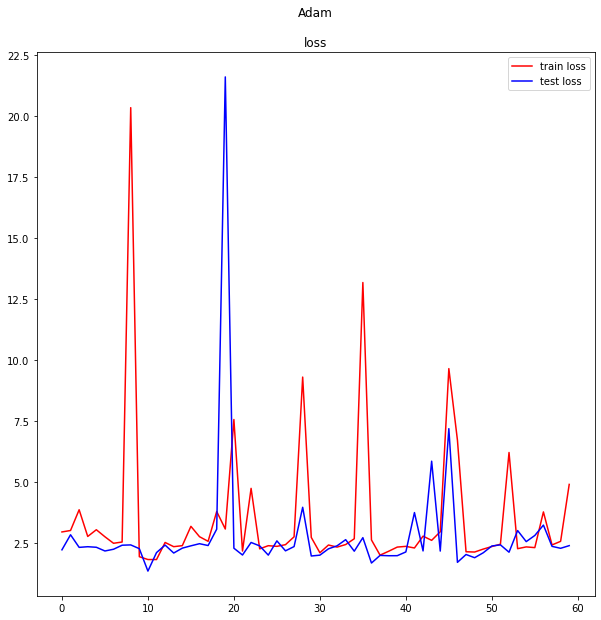

In [42]:
plt.figure(1,figsize=(10,10))

plt.plot(loss_train_adam,label="train loss",c="red")
plt.plot(loss_test_adam,label="test loss",c="blue")
plt.title("Adam\n\nloss")
plt.legend()
plt.plot()

In [43]:
plt.figure(1,figsize=(10,10))

plt.plot(acc_train_arr_adam,label="train accuracy",c="red")
plt.plot(acc_test_arr_adam,label="test accuracy",c="blue")
plt.title("Adam\n\naccuracy")
plt.legend()
plt.plot()

NameError: name 'acc_train_arr_adam' is not defined

<Figure size 720x720 with 0 Axes>

In [ ]:
loss_train_arr, loss_test_arr, accuracy_train_arr, accuracy_test_arr, best_epoch = startTraining(batch_size,epoch,learning_rate_value, "Adam", weight_decay)

In [34]:
print("mini-batch size   32   64  128")
print("training loss  ",loss_train_32[59].round(2),loss_train_64[59].round(2),loss_train_128[59].round(2))
print("testing loss   ",loss_test_32[59].round(2),loss_test_64[59].round(2),loss_test_128[59].round(2))

mini-batch size   32   64  128
training loss   0.0 0.01 0.05
testing loss    0.06 0.06 0.08


In [35]:
print("mini-batch size   32   64  128")
print("training accuracy  ",acc_train_32[59].round(2),acc_train_64[59].round(2),acc_train_128[59].round(2))
print("testing accuracy   ",acc_test_32[59].round(2),acc_test_64[59].round(2),acc_test_128[59].round(2))

mini-batch size   32   64  128
training accuracy   1.0 1.0 0.99
testing accuracy    0.98 0.98 0.98


# Outputs

# 1. Plot the training and testing losses with a batch size of 32 [4pt]

[]

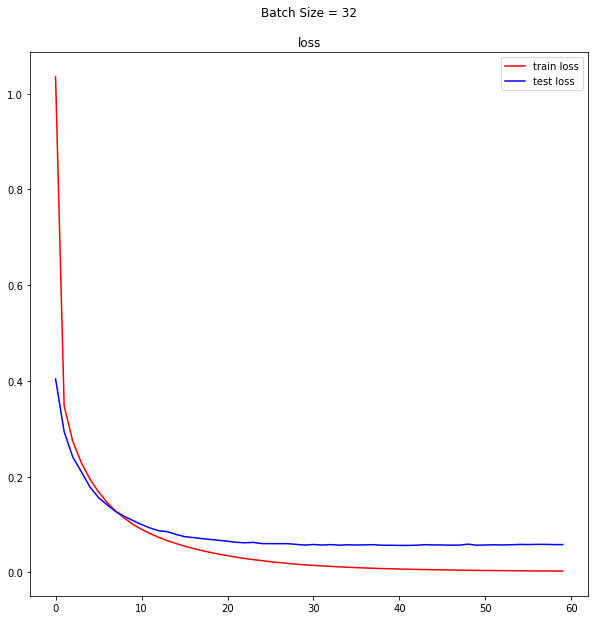

In [36]:
plt.figure(1,figsize=(10,10))

plt.plot(loss_train_32,label="train loss",c="red")
plt.plot(loss_test_32,label="test loss",c="blue")
plt.title("Batch Size = 32\n\nloss")
plt.legend()
plt.plot()

# 2. Plot the training and testing accuracies with a batch size of 32 [4pt]

[]

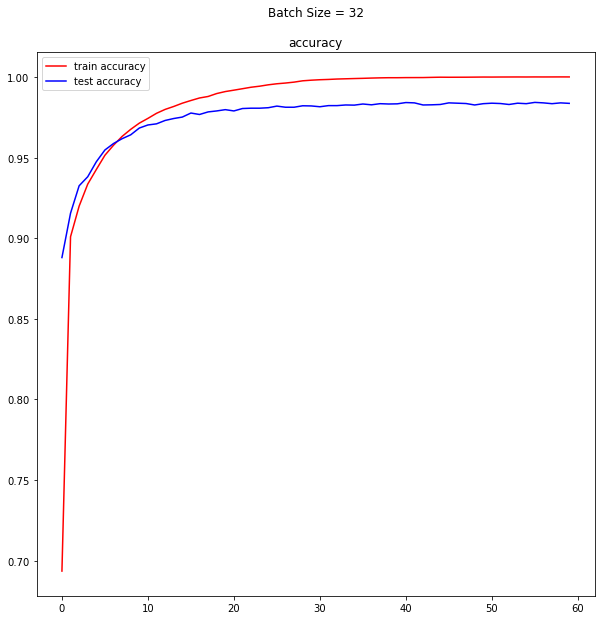

In [37]:
plt.figure(1,figsize=(10,10))

plt.plot(acc_train_32,label="train accuracy",c="red")
plt.plot(acc_test_32,label="test accuracy",c="blue")
plt.title("Batch Size = 32\n\naccuracy")
plt.legend()
plt.plot()

# 3. Plot the training and testing losses with a batch size of 64 [4pt]

[]

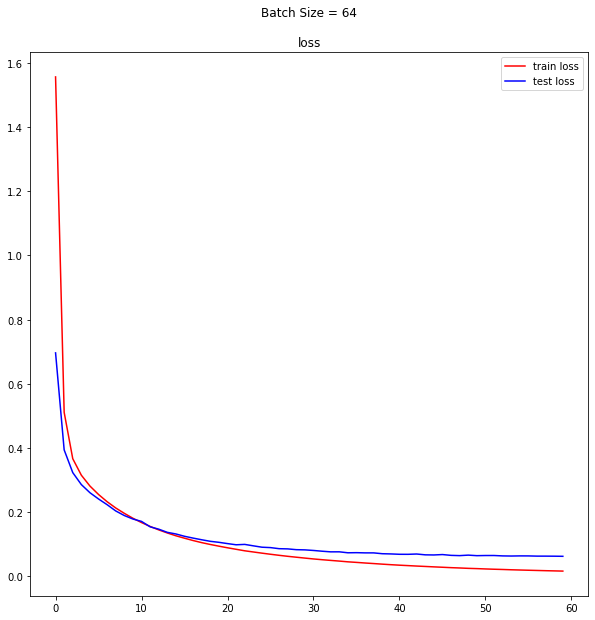

In [38]:
plt.figure(1,figsize=(10,10))

plt.plot(loss_train_64,label="train loss",c="red")
plt.plot(loss_test_64,label="test loss",c="blue")
plt.title("Batch Size = 64\n\nloss")
plt.legend()
plt.plot()

# 4. Plot the training and testing accuracies with a batch size of 64 [4pt]

[]

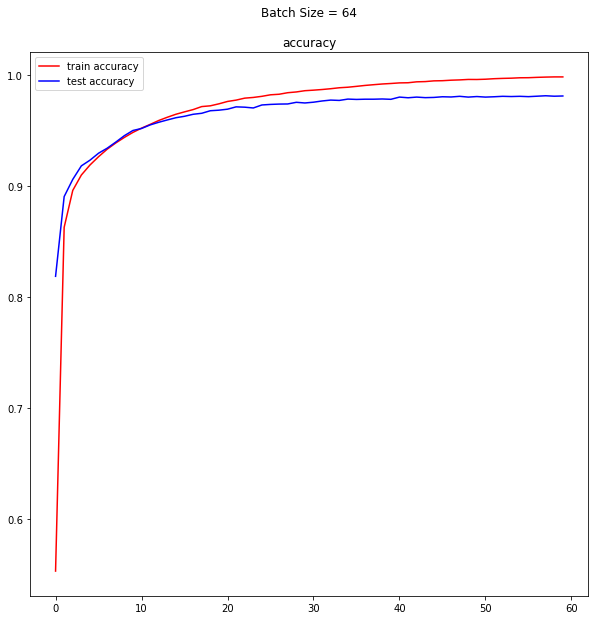

In [39]:
plt.figure(1,figsize=(10,10))

plt.plot(acc_train_64,label="train accuracy",c="red")
plt.plot(acc_test_64,label="test accuracy",c="blue")
plt.title("Batch Size = 64\n\naccuracy")
plt.legend()
plt.plot()

# 5. Plot the training and testing losses with a batch size of 128 [4pt]

[]

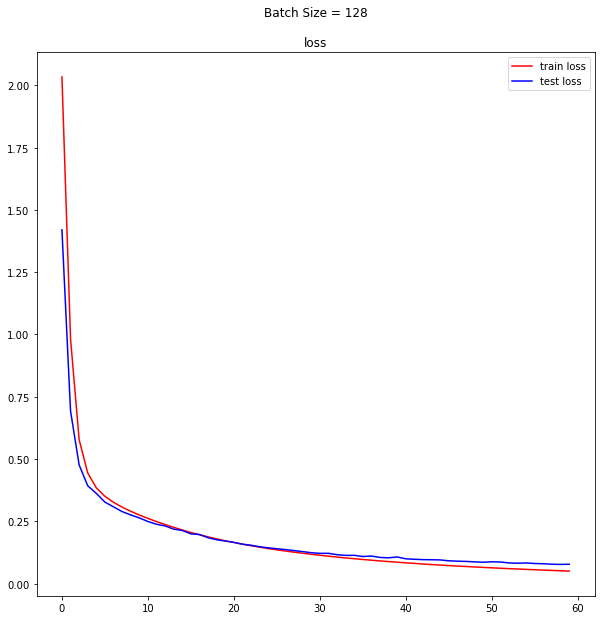

In [40]:
plt.figure(1,figsize=(10,10))

plt.plot(loss_train_128,label="train loss",c="red")
plt.plot(loss_test_128,label="test loss",c="blue")
plt.title("Batch Size = 128\n\nloss")
plt.legend()
plt.plot()

# 6. Plot the training and testing accuracies with a batch size of 128 [4pt]


[]

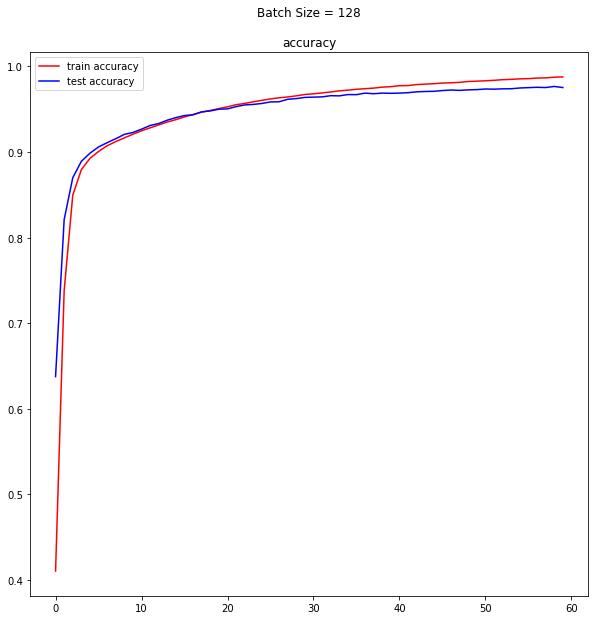

In [41]:
plt.figure(1,figsize=(10,10))

plt.plot(acc_train_128,label="train accuracy",c="red")
plt.plot(acc_test_128,label="test accuracy",c="blue")
plt.title("Batch Size = 128\n\naccuracy")
plt.legend()
plt.plot()

# 7. Print the loss at convergence with different mini-batch sizes [3pt]

In [45]:
print("mini-batch size   32   64  128")
print("training loss  ",loss_train_32[59].round(3),loss_train_64[59].round(3),loss_train_128[59].round(3))
print("testing loss   ",loss_test_32[59].round(3),loss_test_64[59].round(3),loss_test_128[59].round(3))

mini-batch size   32   64  128
training loss   0.003 0.014 0.05
testing loss    0.058 0.06 0.077


# 8. Print the accuracy at convergence with different mini-batch sizes [3pt]

In [47]:
print("mini-batch size      32   64  128")
print("training accuracy  ",acc_train_32[59].round(3),acc_train_64[59].round(3),acc_train_128[59].round(3))
print("testing accuracy   ",acc_test_32[59].round(3),acc_test_64[59].round(3),acc_test_128[59].round(3))

mini-batch size      32   64  128
training accuracy   1.0 0.998 0.988
testing accuracy    0.984 0.981 0.975
